In [1]:
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertModel
# 경고 메시지 무시
warnings.filterwarnings('ignore')

2023-11-27 12:20:35.369122: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 12:20:35.419298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# 데이터 로드
data = pd.read_csv("./data/time.csv")
data = data.drop(columns=["Unnamed: 0"])

In [10]:
data

,노래제목,가수,가사,태그
0,Sunflower (Spider-Man: Into the Spider-Verse),Post Malone(포스트 말론),Ayy ayy ayy ayy Ooh ooh ooh ooh Ayy ayy Ooh oo...,morning
1,Casio,Jungle(정글),Casio Playing on my heart just like a casio Br...,morning
2,Late Night,Lucky Daye,The bigger we are the harder we fall We swingi...,morning
3,Warm On A Cold Night,HONNE(혼네),Okay its AM Youre tuned in with your main ma...,morning
4,How Does It Feel?,Samm Henshaw(샘 핸쇼우),How does it feel to be loved I just landed on ...,morning
...,...,...,...,...
3547,Love Like This,ZAYN(제인)CONNECT 아티스트,Oh I love it when you show when you show When ...,night
3548,Feel Better,Chymes,Verse You say that were fine But i leave feeli...,night
3549,Other Boys,Marshmello(마시멜로),Why cant you want me like the other boys do Th...,night
3550,Lies You Tell,Emotional Oranges,Still tryna find my way out Guess I dont have ...,night


In [4]:
import pandas as pd

# 새로운 데이터프레임 생성
data1 = pd.DataFrame()
data2 = pd.DataFrame()

# 원래 가사를 절반으로 나누어 두 데이터프레임에 추가
for i in range(len(data["가사"])):
    list1 = list(data["가사"][i].split(" "))
    half_length = len(list1) // 2
    first_half = " ".join(list1[:half_length])
    second_half = " ".join(list1[half_length:])
    
    # 첫 번째 데이터프레임에 추가
    data1.loc[i, "가사"] = first_half
    data1.loc[i,"태그"]=data["태그"][i]
    # 두 번째 데이터프레임에 추가
    data2.loc[i, "가사"] = second_half
    data2.loc[i,"태그"]=data["태그"][i]
# 두 데이터프레임 합치기
data = pd.concat([data1, data2], axis=0)

In [14]:
data["태그"].value_counts()

태그
night      1126
noon        925
evening     821
morning     680
Name: count, dtype: int64

In [5]:
data["태그"].value_counts()

태그
night      2252
noon       1850
evening    1642
morning    1360
Name: count, dtype: int64

In [6]:
# BERT 모델 및 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')


2023-11-27 12:20:48.788762: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 12:20:48.796406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 12:20:48.799116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
# 감정 태그를 숫자로 매핑
tag_mapping = {tag: idx for idx, tag in enumerate(data['태그'].unique())}
inverse_tag_mapping = {v: k for k, v in tag_mapping.items()}
data['태그_encoded'] = data['태그'].map(tag_mapping)

# 데이터 분할
train,test= train_test_split(data[["가사",'태그_encoded']], test_size=0.2, random_state=42)

In [10]:
x_train = tokenizer(
    text=train.가사.tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


x_test = tokenizer(
    text=test.가사.tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [12]:
max_len = 100
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert_model(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(256, activation='relu')(out)
out = tf.keras.layers.Dropout(0.3)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(4,activation = 'softmax')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

In [14]:
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy(),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [15]:
# 가사 앞뒤로 나눠서 2배로 늘린 모델
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습에 EarlyStopping 콜백 적용
train_history = model.fit(
    x={'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']},
    y=to_categorical(train.태그_encoded),
    validation_data=(
        {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']},
        to_categorical(test.태그_encoded)),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping]
)


Epoch 1/50
89/89 [==============================] - 26s 130ms/step - loss: 1.3260 - categorical_accuracy: 0.3808 - val_loss: 1.3035 - val_categorical_accuracy: 0.3716
Epoch 2/50
89/89 [==============================] - 9s 98ms/step - loss: 1.2880 - categorical_accuracy: 0.3961 - val_loss: 1.3074 - val_categorical_accuracy: 0.3737
Epoch 3/50
89/89 [==============================] - 9s 101ms/step - loss: 1.2786 - categorical_accuracy: 0.4091 - val_loss: 1.2946 - val_categorical_accuracy: 0.3716
Epoch 4/50
89/89 [==============================] - 9s 98ms/step - loss: 1.2744 - categorical_accuracy: 0.3933 - val_loss: 1.3121 - val_categorical_accuracy: 0.3681
Epoch 5/50
89/89 [==============================] - 9s 102ms/step - loss: 1.2396 - categorical_accuracy: 0.4137 - val_loss: 1.2909 - val_categorical_accuracy: 0.3765
Epoch 6/50
89/89 [==============================] - 9s 101ms/step - loss: 1.1734 - categorical_accuracy: 0.4689 - val_loss: 1.2617 - val_categorical_accuracy: 0.4166
Epoch

In [11]:
# 데이터 원래 앞에만 가져다 쓴 모델
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = to_categorical(train.태그_encoded),
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(test.태그_encoded)),
    epochs=50,
    batch_size=64)

Epoch 1/50
45/45 [==============================] - 30s 216ms/step - loss: 1.3613 - balanced_accuracy: 0.3780 - val_loss: 1.3240 - val_balanced_accuracy: 0.3615
Epoch 2/50
45/45 [==============================] - 8s 168ms/step - loss: 1.2916 - balanced_accuracy: 0.3787 - val_loss: 1.3281 - val_balanced_accuracy: 0.3558
Epoch 3/50
45/45 [==============================] - 8s 169ms/step - loss: 1.2746 - balanced_accuracy: 0.3935 - val_loss: 1.3174 - val_balanced_accuracy: 0.3558
Epoch 4/50
45/45 [==============================] - 8s 169ms/step - loss: 1.2670 - balanced_accuracy: 0.4016 - val_loss: 1.3140 - val_balanced_accuracy: 0.3558
Epoch 5/50
45/45 [==============================] - 8s 169ms/step - loss: 1.2463 - balanced_accuracy: 0.4002 - val_loss: 1.3759 - val_balanced_accuracy: 0.3601
Epoch 6/50
45/45 [==============================] - 8s 169ms/step - loss: 1.2266 - balanced_accuracy: 0.4206 - val_loss: 1.3423 - val_balanced_accuracy: 0.3572
Epoch 7/50
45/45 [=====================

In [16]:
# 예측 결과를 원래 태그로 변환
predictions = model.predict(
   {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_tags = np.argmax(predictions, axis=1)
predicted_tags = [inverse_tag_mapping[tag] for tag in predicted_tags]

print("Predicted Tags:", predicted_tags)


45/45 [==============================] - 3s 22ms/step
Predicted Tags: ['night', 'noon', 'evening', 'noon', 'noon', 'evening', 'evening', 'noon', 'evening', 'noon', 'evening', 'evening', 'evening', 'evening', 'evening', 'evening', 'night', 'night', 'night', 'noon', 'night', 'evening', 'noon', 'noon', 'night', 'evening', 'evening', 'noon', 'evening', 'night', 'night', 'noon', 'noon', 'noon', 'noon', 'evening', 'evening', 'noon', 'evening', 'noon', 'noon', 'noon', 'evening', 'noon', 'evening', 'noon', 'evening', 'evening', 'noon', 'noon', 'night', 'noon', 'noon', 'noon', 'noon', 'night', 'night', 'noon', 'evening', 'noon', 'noon', 'noon', 'night', 'noon', 'night', 'night', 'evening', 'noon', 'evening', 'evening', 'night', 'noon', 'evening', 'evening', 'noon', 'noon', 'night', 'noon', 'noon', 'night', 'noon', 'night', 'noon', 'noon', 'night', 'evening', 'evening', 'noon', 'evening', 'evening', 'noon', 'night', 'noon', 'noon', 'noon', 'noon', 'night', 'evening', 'night', 'noon', 'evening', 

In [17]:
from sklearn.metrics import classification_report

# 예측 결과와 실제 레이블을 가지고 classification report 생성
y_true = test.태그_encoded
y_pred =np.argmax(predictions, axis=1)

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.00      0.01       304
           1       0.46      0.70      0.55       344
           2       0.29      0.48      0.36       318
           3       0.65      0.52      0.57       455

    accuracy                           0.44      1421
   macro avg       0.47      0.42      0.37      1421
weighted avg       0.49      0.44      0.40      1421



In [18]:
model.save_weights('./model/time/time2_weights')
model.save('./model/time/time2.h5')

In [21]:
import matplotlib.pyplot as plt
# 시각화
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

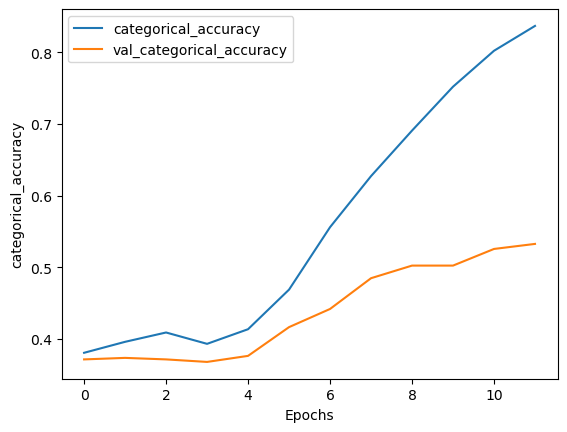

In [24]:
plot_graphs(train_history, 'categorical_accuracy')

In [19]:
a=input()
b=tokenizer(
    text=a,
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

 우울해도 돼 다 괜찮아질 거야 슬퍼해도 돼 다 지나갈 거니까 말해줘도 돼 너의 비밀 같은 것 내가 다시는 안 아프게 해줄게 네가 아픈 것 다 이해할 거야 네가 슬프면 내가 달려갈게 네 마음에 어떤 상처 있어도 내가 마음먹고 낫게 할거야 우울하면 내게 달려와 슬퍼지면 내게 달려와 우울하면 내게 달려와 다 새까맣게 까먹을 수 있게 해줄게 아파해도 돼 금방 나아질 거야 쉬어가도 돼 너무 달려왔잖아 원망해도 돼 네게 상처 준 것들 내가 다시는 혼자 두지 않을게 네가 아픈 것 다 알아줄 거야 말 안 해도 내가 알아채줄게 네게 날카로운 가시 있대도 내가 마음 열어 사랑할 거야 우울하면 내게 달려와 슬퍼지면 내게 달려와 우울하면 내게 달려와 다 새까맣게 까먹을 수 있게 해줄게 우울하면 내게 달려와 슬퍼지면 내게 달려와 우울하면 내게 달려와 다 새까맣게 까먹을 수 있게 해줄게 다 새까맣게 잊고 살아가게 해줄게


In [20]:
predictions2 = model.predict({'input_ids': b['input_ids'], 'attention_mask': b['attention_mask']})
predicted_tags2 = np.argmax(predictions2, axis=1)
predicted_tags2 = [inverse_tag_mapping[tag] for tag in predicted_tags2]
print("Predicted Tags:", predicted_tags2)

1/1 [==============================] - 0s 36ms/step
Predicted Tags: ['night']
